In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data235919


In [2]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [2]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
# !mkdir /home/aistudio/external-libraries
!pip install -r yolov5/requirements.txt # install

Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/, https://pypi.tuna.tsinghua.edu.cn/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.5 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 14.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.2/613.2 kB 15.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 14.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 12.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 18.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 14.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.

In [4]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [5]:
#!git clone https://github.com/ultralytics/yolov5  # clone

In [6]:
STRAWBERRY_LABELS = ['StrawberryIrremovable', 'StrawberryRemovable', 'StrawberryOther', 
                'StrawberryFusiform', 'StrawberryCone', 'StrawberryCircular', 'StrawberryCylindrical',
                'StrawberryWedge']

def get_strawberry_labels():
    """
    return a dict, as following,
        {'StrawberryIrremovable': 0,
         'StrawberryRemovable': 1,
         'StrawberryOther': 2, 
         'StrawberryFusiform': 3,
         'StrawberryCone': 4,
         'StrawberryCircular': 5,
         'StrawberryCylindrical': 6,
         'StrawberryWedge': 7
        }
    It can map the insect name into an integer label.
    """
    strawberry_category2id = {}
    for i, item in enumerate(STRAWBERRY_LABELS):
        strawberry_category2id[item] = i

    return strawberry_category2id

In [7]:
cname2cid = get_strawberry_labels()
cname2cid

{'StrawberryIrremovable': 0,
 'StrawberryRemovable': 1,
 'StrawberryOther': 2,
 'StrawberryFusiform': 3,
 'StrawberryCone': 4,
 'StrawberryCircular': 5,
 'StrawberryCylindrical': 6,
 'StrawberryWedge': 7}

In [8]:
import os
import numpy as np
import xml.etree.ElementTree as ET

def get_annotations(cname2cid, datadir):
    filenames = os.listdir(os.path.join(datadir, 'annotations', 'xmls'))
    records = []
    ct = 0
    for fname in filenames:
        fid = fname.split('.')[0]
        fpath = os.path.join(datadir, 'annotations', 'xmls', fname)
        img_file = os.path.join(datadir, 'images', fid + '.jpeg')
        tree = ET.parse(fpath)

        if tree.find('id') is None:
            im_id = np.array([ct])
        else:
            im_id = np.array([int(tree.find('id').text)])

        objs = tree.findall('object')
        im_w = float(tree.find('size').find('width').text)
        im_h = float(tree.find('size').find('height').text)
        gt_bbox = np.zeros((len(objs), 4), dtype=np.float32)
        gt_class = np.zeros((len(objs), ), dtype=np.int32)
        is_crowd = np.zeros((len(objs), ), dtype=np.int32)
        difficult = np.zeros((len(objs), ), dtype=np.int32)
        for i, obj in enumerate(objs):
            cname = obj.find('name').text
            gt_class[i] = cname2cid[cname]
            _difficult = int(obj.find('difficult').text)
            x1 = float(obj.find('bndbox').find('xmin').text)
            y1 = float(obj.find('bndbox').find('ymin').text)
            x2 = float(obj.find('bndbox').find('xmax').text)
            y2 = float(obj.find('bndbox').find('ymax').text)
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(im_w - 1, x2)
            y2 = min(im_h - 1, y2)
            # 这里使用xywh格式来表示目标物体真实框
            gt_bbox[i] = [(x1+x2)/2.0 , (y1+y2)/2.0, x2-x1+1., y2-y1+1.]
            is_crowd[i] = 0
            difficult[i] = _difficult

        voc_rec = {
            'im_file': img_file,
            'im_id': im_id,
            'h': im_h,
            'w': im_w,
            'is_crowd': is_crowd,
            'gt_class': gt_class,
            'gt_bbox': gt_bbox,
            'gt_poly': [],
            'difficult': difficult
            }
        if len(objs) != 0:
            records.append(voc_rec)
        ct += 1
    return records

In [9]:
#!unzip '/home/aistudio/data/data235919/赛题材料.zip'

In [10]:
import xml.etree.ElementTree as ET

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    labels = []
    
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        # Convert class_name to class_index (0-based index) based on your class mapping
        class_index = cname2cid[class_name]
        
        # Extract bounding box coordinates
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        
        # Calculate YOLO-style coordinates
        width = xmax - xmin
        height = ymax - ymin
        center_x = xmin + width / 2
        center_y = ymin + height / 2
        
        # Normalize coordinates
        image_width = int(root.find('size/width').text)
        image_height = int(root.find('size/height').text)
        normalized_center_x = center_x / image_width
        normalized_center_y = center_y / image_height
        normalized_width = width / image_width
        normalized_height = height / image_height
        
        labels.append(f"{class_index} {normalized_center_x} {normalized_center_y} {normalized_width} {normalized_height}")
    
    return labels


In [11]:
import os
import numpy as np
import shutil

def get_labels(cname2cid):
    filenames = os.listdir(os.path.join('/home/aistudio', '赛题材料', '已标注100张'))
    records = {}
    for fname in filenames:
        if fname.split('.')[1] == 'xml':
            fpath = os.path.join('/home/aistudio', '赛题材料', '已标注100张', fname)
            tree = ET.parse(fpath)
            img_file = tree.find('filename').text
            records = parse_xml(fpath)
            if not os.path.exists('/home/aistudio/work/strawberry/labels/'+ fname.split('.')[0] + '.txt'):
                with open('/home/aistudio/work/strawberry/labels/val/'+ fname.split('.')[0] + '.txt', 'w') as f:
                    f.write('\n'.join(records))
                shutil.copy(r'/home/aistudio/赛题材料/已标注100张/'+ img_file, r'/home/aistudio/work/strawberry/images/val/'+ img_file)

In [12]:
!mkdir /home/aistudio/work/strawberry
!mkdir /home/aistudio/work/strawberry/labels
!mkdir /home/aistudio/work/strawberry/images

In [13]:
!mkdir /home/aistudio/work/strawberry/labels/train
!mkdir /home/aistudio/work/strawberry/images/train
!mkdir /home/aistudio/work/strawberry/labels/val
!mkdir /home/aistudio/work/strawberry/images/val

In [14]:
cname2cid = get_strawberry_labels()
get_labels(cname2cid)

In [15]:
!mkdir /home/aistudio/work/strawberry/test

In [16]:
filenames = os.listdir(os.path.join('/home/aistudio', '赛题材料', '未标注300张'))
for fname in filenames:
    if not os.path.exists(fname):
        shutil.copy(r'/home/aistudio/赛题材料/未标注300张/'+ fname, r'/home/aistudio/work/strawberry/test/'+ fname)

In [17]:
import os
import numpy as np
import xml.etree.ElementTree as ET

def get_annotations(cname2cid, datadir):
    filenames = os.listdir(os.path.join(datadir, '赛题材料', '已标注100张'))
    records = []
    ct = 0
    for fname in filenames:
        if fname.split('.')[1] == 'xml':
            fpath = os.path.join('/home/aistudio', '赛题材料', '已标注100张', fname)
            tree = ET.parse(fpath)

            if tree.find('id') is None:
                im_id = np.array([ct])
            else:
                im_id = np.array([int(tree.find('id').text)])

            img_file = os.path.join('/home/aistudio', '赛题材料', '已标注100张', tree.find('filename').text)
            objs = tree.findall('object')
            im_w = float(tree.find('size').find('width').text)
            im_h = float(tree.find('size').find('height').text)
            gt_bbox = np.zeros((len(objs), 4), dtype=np.float32)
            gt_class = np.zeros((len(objs), ), dtype=np.int32)
            is_crowd = np.zeros((len(objs), ), dtype=np.int32)
            difficult = np.zeros((len(objs), ), dtype=np.int32)
            for i, obj in enumerate(objs):
                cname = obj.find('name').text
                gt_class[i] = cname2cid[cname]
                _difficult = int(obj.find('difficult').text)
                x1 = float(obj.find('bndbox').find('xmin').text)
                y1 = float(obj.find('bndbox').find('ymin').text)
                x2 = float(obj.find('bndbox').find('xmax').text)
                y2 = float(obj.find('bndbox').find('ymax').text)
                x1 = max(0, x1)
                y1 = max(0, y1)
                x2 = min(im_w - 1, x2)
                y2 = min(im_h - 1, y2)
                # 这里使用xywh格式来表示目标物体真实框
                gt_bbox[i] = [(x1+x2)/2.0 , (y1+y2)/2.0, x2-x1+1., y2-y1+1.]
                is_crowd[i] = 0
                difficult[i] = _difficult

            voc_rec = {
                'im_file': img_file,
                'im_id': im_id,
                'h': im_h,
                'w': im_w,
                'is_crowd': is_crowd,
                'gt_class': gt_class,
                'gt_bbox': gt_bbox,
                'gt_poly': [],
                'difficult': difficult
                }
            if len(objs) != 0:
                records.append(voc_rec)
            ct += 1
    return records

In [18]:

TRAINDIR = '/home/aistudio'
records = get_annotations(cname2cid, TRAINDIR)
records[0]

{'im_file': '/home/aistudio/赛题材料/已标注100张/3736055082b81678cf665547fbb29714b56f35de36.jpg',
 'im_id': array([0]),
 'h': 3456.0,
 'w': 4608.0,
 'is_crowd': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], dtype=int32),
 'gt_class': array([0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 1, 1, 6, 1, 2, 0, 0, 2, 2,
        0], dtype=int32),
 'gt_bbox': array([[3077.5, 2718.5,  406. ,  766. ],
        [2775. , 2728.5,  241. ,  256. ],
        [ 655. , 1041. ,  251. ,  311. ],
        [1085. , 1086. ,  131. ,  111. ],
        [1072.5, 1213.5,  186. ,  266. ],
        [1307.5, 1151. ,  196. ,  271. ],
        [ 400. , 1196. ,  171. ,  191. ],
        [1380. , 1533.5,  361. ,  496. ],
        [1412.5, 1863.5,  206. ,  256. ],
        [ 397.5, 1193.5,  186. ,  206. ],
        [2227.5, 2671. ,  186. ,  271. ],
        [2200. , 2371. ,  391. ,  421. ],
        [1875. , 2481. ,  321. ,  521. ],
        [1587.5, 2096. ,  446. ,  421. ],
        [1607.5, 2518.5,  416. ,  626

In [19]:
# 数据读取
import cv2
def get_bbox(gt_bbox, gt_class):
    # 对于一般的检测任务来说，一张图片上往往会有多个目标物体
    # 设置参数MAX_NUM = 50， 即一张图片最多取50个真实框；如果真实
    # 框的数目少于50个，则将不足部分的gt_bbox, gt_class和gt_score的各项数值全设置为0
    MAX_NUM = 50
    gt_bbox2 = np.zeros((MAX_NUM, 4))
    gt_class2 = np.zeros((MAX_NUM,))
    try:
      for i in range(min(len(gt_bbox2), len(gt_bbox))):
          gt_bbox2[i, :] = gt_bbox[i, :]
          gt_class2[i] = gt_class[i]
          if i >= MAX_NUM:
              break
      return gt_bbox2, gt_class2
    except Exception as e:
      print(gt_bbox2.shape, gt_bbox.shape)


def get_img_data_from_file(record):
    """
    record is a dict as following,
      record = {
            'im_file': img_file,
            'im_id': im_id,
            'h': im_h,
            'w': im_w,
            'is_crowd': is_crowd,
            'gt_class': gt_class,
            'gt_bbox': gt_bbox,
            'gt_poly': [],
            'difficult': difficult
            }
    """
    im_file = record['im_file']
    h = record['h']
    w = record['w']
    is_crowd = record['is_crowd']
    gt_class = record['gt_class']
    gt_bbox = record['gt_bbox']
    difficult = record['difficult']

    img = cv2.imread(im_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if img.shape[0] != int(h):
      if img.shape[0] == int(w):
        sw = h
        h = w
        w = sw

    # check if h and w in record equals that read from img
    assert img.shape[0] == int(h), \
             "image height of {} inconsistent in record({}) and img file({})".format(
               record['im_id'], h, img.shape[0])

    assert img.shape[1] == int(w), \
             "image width of {} inconsistent in record({}) and img file({})".format(
               im_file, w, img.shape[1])

    gt_boxes, gt_labels = get_bbox(gt_bbox, gt_class)

    # gt_bbox 用相对值
    gt_boxes[:, 0] = gt_boxes[:, 0] / float(w)
    gt_boxes[:, 1] = gt_boxes[:, 1] / float(h)
    gt_boxes[:, 2] = gt_boxes[:, 2] / float(w)
    gt_boxes[:, 3] = gt_boxes[:, 3] / float(h)
  
    return img, gt_boxes, gt_labels, (h, w)

read image from file /home/aistudio/赛题材料/已标注100张/3736055082b81678cf665547fbb29714b56f35de36.jpg


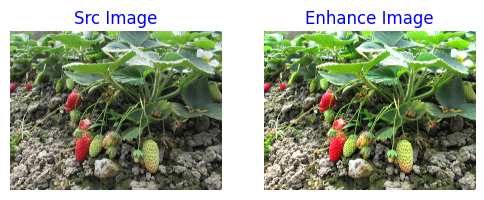

In [20]:
import numpy as np
import cv2
from PIL import Image, ImageEnhance
import random

# 随机改变亮暗、对比度和颜色等
def random_distort(img):
    # 随机改变亮度
    def random_brightness(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Brightness(img).enhance(e)
    # 随机改变对比度
    def random_contrast(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Contrast(img).enhance(e)
    # 随机改变颜色
    def random_color(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Color(img).enhance(e)

    ops = [random_brightness, random_contrast, random_color]
    np.random.shuffle(ops)

    img = Image.fromarray(img)
    img = ops[0](img)
    img = ops[1](img)
    img = ops[2](img)
    img = np.asarray(img)

    return img

# 定义可视化函数，用于对比原图和图像增强的效果
import matplotlib.pyplot as plt
def visualize(srcimg, img_enhance):
    # 图像可视化
    plt.figure(num=2, figsize=(6,12))
    plt.subplot(1,2,1)
    plt.title('Src Image', color='#0000FF')
    plt.axis('off') # 不显示坐标轴
    plt.imshow(srcimg) # 显示原图片

    # 对原图做 随机改变亮暗、对比度和颜色等 数据增强
    srcimg_gtbox = records[0]['gt_bbox']
    srcimg_label = records[0]['gt_class']

    plt.subplot(1,2,2)
    plt.title('Enhance Image', color='#0000FF')
    plt.axis('off') # 不显示坐标轴
    plt.imshow(img_enhance)



image_path = records[0]['im_file']
print("read image from file {}".format(image_path))
srcimg = Image.open(image_path)
# 将PIL读取的图像转换成array类型
srcimg = np.array(srcimg)

# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
img_enhance = random_distort(srcimg)
visualize(srcimg, img_enhance)


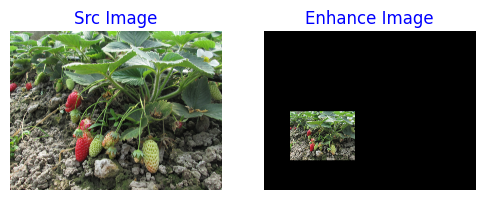

In [21]:
def random_expand(img,
                  gtboxes,
                  max_ratio=4.,
                  fill=None,
                  keep_ratio=True,
                  thresh=0.5):
    if random.random() > thresh:
        return img, gtboxes

    if max_ratio < 1.0:
        return img, gtboxes

    h, w, c = img.shape
    ratio_x = random.uniform(1, max_ratio)
    if keep_ratio:
        ratio_y = ratio_x
    else:
        ratio_y = random.uniform(1, max_ratio)
    oh = int(h * ratio_y)
    ow = int(w * ratio_x)
    off_x = random.randint(0, ow - w)
    off_y = random.randint(0, oh - h)

    out_img = np.zeros((oh, ow, c))
    if fill and len(fill) == c:
        for i in range(c):
            out_img[:, :, i] = fill[i] * 255.0

    out_img[off_y:off_y + h, off_x:off_x + w, :] = img
    gtboxes[:, 0] = ((gtboxes[:, 0] * w) + off_x) / float(ow)
    gtboxes[:, 1] = ((gtboxes[:, 1] * h) + off_y) / float(oh)
    gtboxes[:, 2] = gtboxes[:, 2] / ratio_x
    gtboxes[:, 3] = gtboxes[:, 3] / ratio_y

    return out_img.astype('uint8'), gtboxes


# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
srcimg_gtbox = records[0]['gt_bbox']
img_enhance, new_gtbox = random_expand(srcimg, srcimg_gtbox)
visualize(srcimg, img_enhance)

In [22]:
import numpy as np

def multi_box_iou_xywh(box1, box2):
    """
    In this case, box1 or box2 can contain multi boxes.
    Only two cases can be processed in this method:
       1, box1 and box2 have the same shape, box1.shape == box2.shape
       2, either box1 or box2 contains only one box, len(box1) == 1 or len(box2) == 1
    If the shape of box1 and box2 does not match, and both of them contain multi boxes, it will be wrong.
    """
    assert box1.shape[-1] == 4, "Box1 shape[-1] should be 4."
    assert box2.shape[-1] == 4, "Box2 shape[-1] should be 4."


    b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
    b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
    b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
    b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2

    inter_x1 = np.maximum(b1_x1, b2_x1)
    inter_x2 = np.minimum(b1_x2, b2_x2)
    inter_y1 = np.maximum(b1_y1, b2_y1)
    inter_y2 = np.minimum(b1_y2, b2_y2)
    inter_w = inter_x2 - inter_x1
    inter_h = inter_y2 - inter_y1
    inter_w = np.clip(inter_w, a_min=0., a_max=None)
    inter_h = np.clip(inter_h, a_min=0., a_max=None)

    inter_area = inter_w * inter_h
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)

    return inter_area / (b1_area + b2_area - inter_area)

def box_crop(boxes, labels, crop, img_shape):
    x, y, w, h = map(float, crop)
    im_w, im_h = map(float, img_shape)

    boxes = boxes.copy()
    boxes[:, 0], boxes[:, 2] = (boxes[:, 0] - boxes[:, 2] / 2) * im_w, (
        boxes[:, 0] + boxes[:, 2] / 2) * im_w
    boxes[:, 1], boxes[:, 3] = (boxes[:, 1] - boxes[:, 3] / 2) * im_h, (
        boxes[:, 1] + boxes[:, 3] / 2) * im_h

    crop_box = np.array([x, y, x + w, y + h])
    centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0
    mask = np.logical_and(crop_box[:2] <= centers, centers <= crop_box[2:]).all(
        axis=1)

    boxes[:, :2] = np.maximum(boxes[:, :2], crop_box[:2])
    boxes[:, 2:] = np.minimum(boxes[:, 2:], crop_box[2:])
    boxes[:, :2] -= crop_box[:2]
    boxes[:, 2:] -= crop_box[:2]

    mask = np.logical_and(mask, (boxes[:, :2] < boxes[:, 2:]).all(axis=1))
    boxes = boxes * np.expand_dims(mask.astype('float32'), axis=1)
    labels = labels * mask.astype('float32')
    boxes[:, 0], boxes[:, 2] = (boxes[:, 0] + boxes[:, 2]) / 2 / w, (
        boxes[:, 2] - boxes[:, 0]) / w
    boxes[:, 1], boxes[:, 3] = (boxes[:, 1] + boxes[:, 3]) / 2 / h, (
        boxes[:, 3] - boxes[:, 1]) / h

    return boxes, labels, mask.sum()

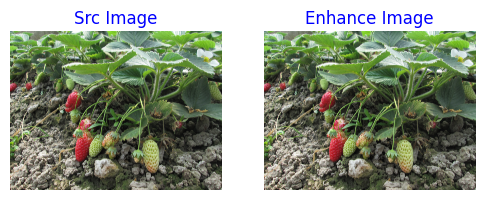

In [23]:
# 随机裁剪
def random_crop(img,
                boxes,
                labels,
                scales=[0.3, 1.0],
                max_ratio=2.0,
                constraints=None,
                max_trial=50):
    if len(boxes) == 0:
        return img, boxes

    if not constraints:
        constraints = [(0.1, 1.0), (0.3, 1.0), (0.5, 1.0), (0.7, 1.0),
                       (0.9, 1.0), (0.0, 1.0)]

    img = Image.fromarray(img)
    w, h = img.size
    crops = [(0, 0, w, h)]
    for min_iou, max_iou in constraints:
        for _ in range(max_trial):
            scale = random.uniform(scales[0], scales[1])
            aspect_ratio = random.uniform(max(1 / max_ratio, scale * scale), \
                                          min(max_ratio, 1 / scale / scale))
            crop_h = int(h * scale / np.sqrt(aspect_ratio))
            crop_w = int(w * scale * np.sqrt(aspect_ratio))
            crop_x = random.randrange(w - crop_w)
            crop_y = random.randrange(h - crop_h)
            crop_box = np.array([[(crop_x + crop_w / 2.0) / w,
                                  (crop_y + crop_h / 2.0) / h,
                                  crop_w / float(w), crop_h / float(h)]])

            iou = multi_box_iou_xywh(crop_box, boxes)
            if min_iou <= iou.min() and max_iou >= iou.max():
                crops.append((crop_x, crop_y, crop_w, crop_h))
                break

    while crops:
        crop = crops.pop(np.random.randint(0, len(crops)))
        crop_boxes, crop_labels, box_num = box_crop(boxes, labels, crop, (w, h))
        if box_num < 1:
            continue
        img = img.crop((crop[0], crop[1], crop[0] + crop[2],
                        crop[1] + crop[3])).resize(img.size, Image.LANCZOS)
        img = np.asarray(img)
        return img, crop_boxes, crop_labels
    img = np.asarray(img)
    return img, boxes, labels


# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
srcimg_gtbox = records[0]['gt_bbox']
srcimg_label = records[0]['gt_class']

img_enhance, new_labels, mask = random_crop(srcimg, srcimg_gtbox, srcimg_label)
visualize(srcimg, img_enhance)

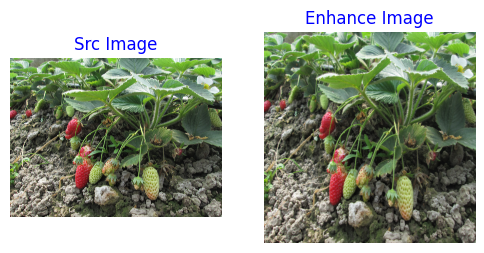

In [24]:
# 随机缩放
def random_interp(img, size, interp=None):
    interp_method = [
        cv2.INTER_NEAREST,
        cv2.INTER_LINEAR,
        cv2.INTER_AREA,
        cv2.INTER_CUBIC,
        cv2.INTER_LANCZOS4,
    ]
    if not interp or interp not in interp_method:
        interp = interp_method[random.randint(0, len(interp_method) - 1)]
    h, w, _ = img.shape
    im_scale_x = size / float(w)
    im_scale_y = size / float(h)
    img = cv2.resize(
        img, None, None, fx=im_scale_x, fy=im_scale_y, interpolation=interp)
    return img

# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
img_enhance = random_interp(srcimg, 640)
visualize(srcimg, img_enhance)

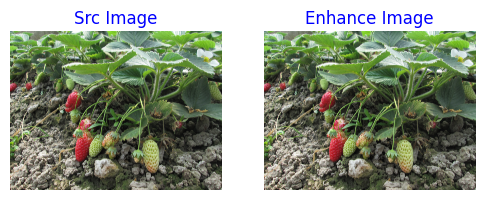

In [25]:
# 随机翻转
def random_flip(img, gtboxes, thresh=0.5):
    if random.random() > thresh:
        img = img[:, ::-1, :]
        gtboxes[:, 0] = 1.0 - gtboxes[:, 0]
    return img, gtboxes


# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
img_enhance, box_enhance = random_flip(srcimg, srcimg_gtbox)
visualize(srcimg, img_enhance)

In [26]:
# 随机打乱真实框排列顺序
def shuffle_gtbox(gtbox, gtlabel):
    gt = np.concatenate(
        [gtbox, gtlabel[:, np.newaxis]], axis=1)
    idx = np.arange(gt.shape[0])
    np.random.shuffle(idx)
    gt = gt[idx, :]
    return gt[:, :4], gt[:, 4]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


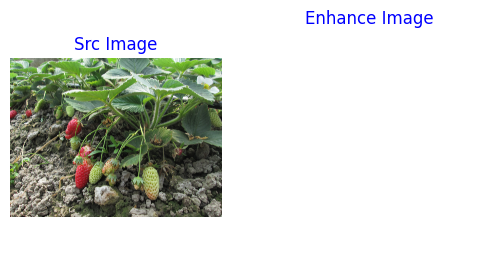

In [27]:
# 图像增广方法汇总
def image_augment(img, gtboxes, gtlabels, size, means=None):
    # 随机改变亮暗、对比度和颜色等
    img = random_distort(img)
    # 随机填充
    img, gtboxes = random_expand(img, gtboxes, fill=means)
    # 随机裁剪
    img, gtboxes, gtlabels, = random_crop(img, gtboxes, gtlabels)
    # 随机缩放
    img = random_interp(img, size)
    # 随机翻转
    img, gtboxes = random_flip(img, gtboxes)
    # 随机打乱真实框排列顺序
    gtboxes, gtlabels = shuffle_gtbox(gtboxes, gtlabels)

    return img.astype('float32'), gtboxes.astype('float32'), gtlabels.astype('int32')

img_enhance, img_box, img_label = image_augment(srcimg, srcimg_gtbox, srcimg_label, size=320)
visualize(srcimg, img_enhance)

In [28]:
def get_img_data(record, size=640):
    img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
    img, gt_boxes, gt_labels = image_augment(img, gt_boxes, gt_labels, size)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    mean = np.array(mean).reshape((1, 1, -1))
    std = np.array(std).reshape((1, 1, -1))
    img = (img / 255.0 - mean) / std
    img = img.astype('float32').transpose((2, 0, 1))
    return img, gt_boxes, gt_labels, scales

In [29]:
record = records[0]
img, gt_boxes, gt_labels, scales = get_img_data(record, size=480)

In [30]:
# 获取一个批次内样本随机缩放的尺寸
def get_img_size(mode):
    if (mode == 'train') or (mode == 'valid'):
        inds = np.array([0,1,2,3,4,5,6,7,8,9])
        ii = np.random.choice(inds)
        img_size = 320 + ii * 32
    else:
        img_size = 608
    return img_size

# 将 list形式的batch数据 转化成多个array构成的tuple
def make_array(batch_data):
    img_array = np.array([item[0] for item in batch_data], dtype = 'float32')
    gt_box_array = np.array([item[1] for item in batch_data], dtype = 'float32')
    gt_labels_array = np.array([item[2] for item in batch_data], dtype = 'int32')
    img_scale = np.array([item[3] for item in batch_data], dtype='int32')
    return img_array, gt_box_array, gt_labels_array, img_scale

# 批量读取数据，同一批次内图像的尺寸大小必须是一样的，
# 不同批次之间的大小是随机的，
# 由上面定义的get_img_size函数产生
def data_loader(datadir, batch_size= 10, mode='train'):
    cname2cid = get_strawberry_labels()
    records = get_annotations(cname2cid, datadir)

    def reader():
        if mode == 'train':
            np.random.shuffle(records)
        batch_data = []
        img_size = get_img_size(mode)
        for record in records:
            #print(record)
            img, gt_bbox, gt_labels, im_shape = get_img_data(record, 
                                                             size=img_size)
            batch_data.append((img, gt_bbox, gt_labels, im_shape))
            if len(batch_data) == batch_size:
                yield make_array(batch_data)
                batch_data = []
                img_size = get_img_size(mode)
        if len(batch_data) > 0:
            yield make_array(batch_data)

    return reader

In [31]:
d = data_loader('/home/aistudio', batch_size=10, mode='train')

In [35]:
import matplotlib.image as mpimg
def get_augment_imgs(img, gt_boxes, gt_labels, im_shape, records):
    global new_img_name
    for i in range(len(img)):
        contents = []
        filenames = '/home/aistudio/work/strawberry/images/train/train' + str(new_img_name) + '.jpg'
        for j in range(len(gt_labels)):
            gt_label = gt_labels[j]
            normalized_center_x = gt_boxes[j][0]
            normalized_center_y = gt_boxes[j][1]
            normalized_width = gt_boxes[j][2]
            normalized_height = gt_boxes[j][3]
            contents.append(f"{gt_label} {normalized_center_x} {normalized_center_y} {normalized_width} {normalized_height}")
        if not os.path.exists('/home/aistudio/work/strawberry/labels/train/train'+ str(new_img_name) + '.txt'):
            with open('/home/aistudio/work/strawberry/labels/train/train'+ str(new_img_name) + '.txt', 'w') as f:
                f.write('\n'.join(contents))
            mpimg.imsave(filenames, img[i])
            new_img_name += 1

In [33]:
Image.MAX_IMAGE_PIXELS = None

In [36]:
new_img_name = 0
for i in range(11):
    img, gt_boxes, gt_labels, im_shape = next(d())
    for j in range(len(img)):
        get_augment_imgs(img[j], gt_boxes[j], gt_labels[j], im_shape[j], records)


In [38]:
import yaml
dic = {
    # Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
'path': '/home/aistudio/work/strawberry',  # dataset root dir
'train': 'images/train', # train images (relative to 'path') 128 images
'val': 'images/val',  # val images (relative to 'path') 128 images
'test':  'test', # test images (optional)

# Classes (80 COCO classes)
'names':{
  0: 'StrawberryIrremovable',
  1: 'StrawberryRemovable',
  2: 'StrawberryOther',
  3: 'StrawberryFusiform',
  4: 'StrawberryCone',
  5: 'StrawberryCircular',
  6: 'StrawberryCylindrical',
  7: 'StrawberryWedge'
    }
}
yaml_path = os.path.join('/home/aistudio/work/strawberry', 'strawberry.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(dic, f)

In [ ]:
#!python /home/aistudio/yolov5/train.py --batch 48 --weights yolov5s.pt --data /home/aistudio/data/strawberry/strawberry.yaml --epochs 50 --cache --img 640 --freeze 10

In [ ]:
#!python /home/aistudio/yolov5/detect.py --weights /home/aistudio/yolov5/runs/train/exp4/weights/best.pt --source /home/aistudio/data/strawberry/test --save-txt

In [40]:
!mkdir /home/aistudio/work/strawberry/test_1

In [41]:
filenames1 = os.listdir(os.path.join('/home/aistudio', '赛题材料', '未标注300张'))
filenames2 = os.listdir(os.path.join('/home/aistudio', 'yolov5/runs/detect/exp2/labels'))
filenames3 = os.listdir(os.path.join('/home/aistudio', '赛题材料' , '测评集'))
for fname in filenames1:
    if not os.path.exists(fname):
        shutil.copy(r'/home/aistudio/赛题材料/未标注300张/'+ fname, r'/home/aistudio/work/strawberry/images/train/'+ fname)

for fname in filenames2:
    if not os.path.exists(fname):
        shutil.copy(r'/home/aistudio/yolov5/runs/detect/exp2/labels/'+ fname, r'/home/aistudio/work/strawberry/labels/train/'+ fname)

for fname in filenames3:
    if not os.path.exists(fname):
        shutil.copy(r'/home/aistudio/赛题材料/测评集/'+ fname, r'/home/aistudio/work/strawberry/test_1/'+ fname)



In [2]:
!python /home/aistudio/yolov5/train.py --img 640 --epochs 25 --data /home/aistudio/work/strawberry/strawberry.yaml --weights yolov5s.pt                              

train: weights=yolov5s.pt, cfg=, data=/home/aistudio/work/strawberry/strawberry.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=0, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 2 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-210-gdd10481 Python-3.10.10 torch-2.0.1+cu117 CUDA:0 (Tesla V100-SXM2-32GB, 32510MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box

In [7]:
!python /home/aistudio/yolov5/detect.py --weights /home/aistudio/yolov5/runs/train/exp19/weights/best.pt --source /home/aistudio/work/strawberry/test_1 --save-txt --save-conf

detect: weights=['/home/aistudio/yolov5/runs/train/exp19/weights/best.pt'], source=/home/aistudio/work/strawberry/test_1, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-210-gdd10481 Python-3.10.10 torch-2.0.1+cu117 CUDA:0 (Tesla V100-SXM2-32GB, 32510MiB)

Fusing layers... 
Model summary: 157 layers, 7031701 parameters, 0 gradients, 15.8 GFLOPs
image 1/50 /home/aistudio/work/strawberry/test_1/0639620630586fd78b76954130b49fed552033343b.jpg: 480x640 7 StrawberryIrremovables, 2 StrawberryRemovables, 61.6ms
image 2/50 /home/aistudio/work/strawberry/test_1/09367430219cedf375f8794eca9f50a646b9ceda29.JPG: 480x640 4 StrawberryI